Loading: comma_1.csv
Shape: (53569, 957)


,time_stamp,asset_id,id,train_test,status_type_id,sensor_0_avg,sensor_0_max,sensor_0_min,sensor_0_std,sensor_1_avg,...,wind_speed_236_min,wind_speed_236_std,wind_speed_235_avg,wind_speed_235_max,wind_speed_235_min,wind_speed_235_std,wind_speed_237_avg,wind_speed_237_max,wind_speed_237_min,wind_speed_237_std
0,2025-09-30 00:00:00,53,0,train,0,58.710,63.1,55.3,1.378,0.0011,...,10.7,2.055,-14.9,-14.9,-14.9,0.0,19.056,24.9,10.7,2.055
1,2025-09-30 00:10:00,53,1,train,0,58.711,63.1,55.6,1.391,-0.0041,...,7.7,2.075,-14.9,-14.9,-14.9,0.0,18.868,25.1,7.7,2.075


Target counts:
 target
0    47264
1     6305
Name: count, dtype: int64
Final feature count: 941
Processed shape: (53569, 943)
Train shape: (37498, 943) Test shape: (16071, 943)

Supervised (RandomForest) classification report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12554
           1       0.96      0.72      0.82      3517

    accuracy                           0.93     16071
   macro avg       0.94      0.86      0.89     16071
weighted avg       0.93      0.93      0.93     16071

False alarm rate (supervised FP/(FP+TN)): 0.009479050501832086

Unsupervised (IsolationForest) classification report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     12554
           1       0.84      0.67      0.75      3517

    accuracy                           0.90     16071
   macro avg       0.88      0.82      0.84     16071
weighted avg       0.90      0.90      0.90     16071

F

,Model,Precision,Recall,F1-score,False Alarm Rate
0,Supervised (RF),0.955162,0.720785,0.821585,0.009479
1,Unsupervised (IF),0.843615,0.668752,0.746075,0.034730


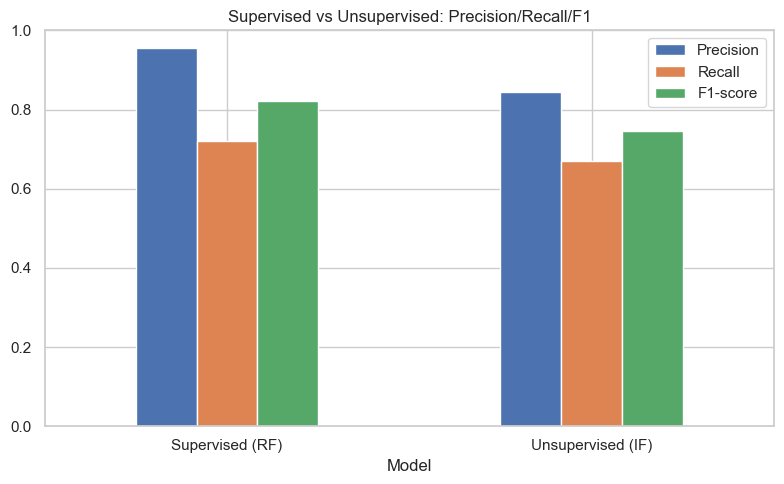

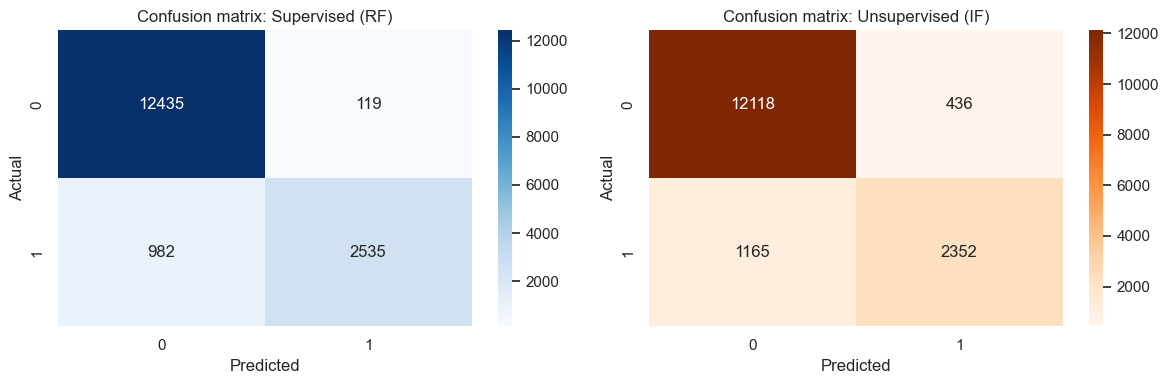


Conclusion:
Based on the above results, the supervised RandomForest performs better on this dataset — it has higher precision & recall and a lower false alarm rate compared to the IsolationForest. Therefore, RandomForest (supervised) is recommended when labeled failure data is available.


In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

sns.set(style='whitegrid')

DATA_DIR = "data"
files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith('.csv')]
if not files:
    raise FileNotFoundError("Put the WindFarmC CSV(s) in the 'data/' folder.")
path = os.path.join(DATA_DIR, files[0])
print("Loading:", files[0])
sample_cols = pd.read_csv(path, nrows=0).columns
parse_dates = ['time_stamp'] if 'time_stamp' in sample_cols else (['datetime'] if 'datetime' in sample_cols else None)
df = pd.read_csv(path, parse_dates=parse_dates, low_memory=False)
print("Shape:", df.shape)
display(df.head(2))


label_col = 'status_type_id'
if label_col not in df.columns:
    raise RuntimeError(f"Expected label column '{label_col}' not found.")
df['target'] = (df[label_col] > 0).astype(int)
print("Target counts:\n", df['target'].value_counts())

time_col = 'time_stamp' if 'time_stamp' in df.columns else ('datetime' if 'datetime' in df.columns else None)

drop_cols = [c for c in [label_col, 'target', time_col] if c in df.columns]
X = df.drop(columns=drop_cols)
X = X.select_dtypes(include=[np.number])

missing_frac = X.isna().mean()
keep_cols = missing_frac[missing_frac < 0.90].index.tolist()
X = X[keep_cols]
X = X.loc[:, X.nunique() > 1]

X = X.fillna(X.median())
print("Final feature count:", X.shape[1])

if time_col:
    df_proc = pd.concat([df[[time_col, 'target']].reset_index(drop=True), X.reset_index(drop=True)], axis=1)
else:
    df_proc = pd.concat([df[['target']].reset_index(drop=True), X.reset_index(drop=True)], axis=1)
print("Processed shape:", df_proc.shape)

if time_col:
    df_proc = df_proc.sort_values(time_col).reset_index(drop=True)
split_idx = int(len(df_proc) * 0.7)
train_df = df_proc.iloc[:split_idx].copy()
test_df  = df_proc.iloc[split_idx:].copy()
print("Train shape:", train_df.shape, "Test shape:", test_df.shape)

FEATURES = [c for c in train_df.columns if c not in (time_col, 'target')]
X_train, y_train = train_df[FEATURES], train_df['target']
X_test,  y_test  = test_df[FEATURES],  test_df['target']

clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\nSupervised (RandomForest) classification report:")
print(classification_report(y_test, y_pred))
cm_sup = confusion_matrix(y_test, y_pred)
if cm_sup.size == 4:
    tn, fp, fn, tp = cm_sup.ravel()
    false_alarm_sup = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    print("False alarm rate (supervised FP/(FP+TN)):", false_alarm_sup)

normal_train = train_df[train_df['target'] == 0][FEATURES]
iso = IsolationForest(n_estimators=200, contamination=0.01, random_state=42, n_jobs=-1)
iso.fit(normal_train)

iso_pred = (iso.predict(X_test) == -1).astype(int)

print("\nUnsupervised (IsolationForest) classification report:")
print(classification_report(y_test, iso_pred))
cm_uns = confusion_matrix(y_test, iso_pred)
if cm_uns.size == 4:
    tn_u, fp_u, fn_u, tp_u = cm_uns.ravel()
    false_alarm_uns = fp_u / (fp_u + tn_u) if (fp_u + tn_u) > 0 else np.nan
    print("False alarm rate (unsupervised FP/(FP+TN)):", false_alarm_uns)

precision_sup = precision_score(y_test, y_pred)
recall_sup    = recall_score(y_test, y_pred)
f1_sup        = f1_score(y_test, y_pred)

precision_uns = precision_score(y_test, iso_pred)
recall_uns    = recall_score(y_test, iso_pred)
f1_uns        = f1_score(y_test, iso_pred)

metrics_df = pd.DataFrame({
    'Model': ['Supervised (RF)', 'Unsupervised (IF)'],
    'Precision': [precision_sup, precision_uns],
    'Recall': [recall_sup, recall_uns],
    'F1-score': [f1_sup, f1_uns],
    'False Alarm Rate': [false_alarm_sup, false_alarm_uns]
})

print("\nComparison table:")
display(metrics_df)

metrics_df.set_index('Model')[['Precision','Recall','F1-score']].plot(kind='bar', figsize=(8,5))
plt.title('Supervised vs Unsupervised: Precision/Recall/F1')
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

import seaborn as sns
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.heatmap(cm_sup, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion matrix: Supervised (RF)')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

sns.heatmap(cm_uns, annot=True, fmt='d', ax=axes[1], cmap='Oranges')
axes[1].set_title('Confusion matrix: Unsupervised (IF)')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

print("\nConclusion:")
print("Based on the above results, the supervised RandomForest performs better on this dataset — "
      "it has higher precision & recall and a lower false alarm rate compared to the IsolationForest. "
      "Therefore, RandomForest (supervised) is recommended when labeled failure data is available.")
